<a href="https://colab.research.google.com/github/MarcosVeniciu/Xception_CNN_Dogs_vs_Cats/blob/main/Xception_pre_treinada_Dogs_vs_Cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuração do DataSet [1][2]

In [1]:
# Intalação do keggle

! pip install -q kaggle

## Configurando acesso a API 

importar o arquivo keggle.json que foi baixado com as informações da API \
Não apagar o arquivo do PC, pois vai precisar dele sempre que abrir o cloab. 


In [ ]:
# Lê o arquivo Kaggle.json

from google.colab import files
files.upload()

In [3]:
# Cria uma pasta chamada Keggle e copia o arquivo Json para ela.
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

# Altera as permisções para o arquivo keggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Verifica uma lista de dataset do keggle. Se a lista for exibida, esntão ta tudo certo. (opcional)
! kaggle datasets list

## Donwload do DataSet

In [4]:
# Download do DataSet [3]
# É preciso aceitar as regras na aba de Rules na pagina do dataset[4] para poder fazer o download do dataset

! kaggle competitions download -c dogs-vs-cats

 98% 792M/812M [00:03<00:00, 220MB/s]
100% 812M/812M [00:04<00:00, 209MB/s]


In [5]:
# Cria uma pasta chamada Dog_Cat
! mkdir Dog_Cat

In [6]:
# Descompacta o arquivo dog-vs-cats na pasta Dog_Cat

! unzip dogs-vs-cats.zip -d Dog_Cat

Archive:  dogs-vs-cats.zip
  inflating: Dog_Cat/sampleSubmission.csv  
  inflating: Dog_Cat/test1.zip       
  inflating: Dog_Cat/train.zip       


O arquivo dogs-vs-cats.zip tem dois outros arquivos zip. \
train.zip que é a pasta onde estão as imagens para o treino e para a validação. \
test1.zip é onde estão as imagens que não são usadas para o treino e para a valiaçaõ. Elas são as imanges de cães e gatos para realizar os testes.

In [ ]:
# Descompacta as imagens para o teste, que estão no arquivo test1.zip para a pasta Dog_Cat

! unzip Dog_Cat/test1.zip -d Dog_Cat

In [ ]:
# Descompacta as imagens de treino e validação que estão no arquivo train.zip para a pasta Dog_Cat
! unzip Dog_Cat/train.zip -d Dog_Cat

In [9]:
# renomeia as pastas
# os.rename('/pasta/subpasta/nome_atual', /pasta/subpasta/novo_nome')

import os

os.rename('/content/Dog_Cat/train', '/content/Dog_Cat/dataset') # renomeia a pasta train para dataset_treino
os.rename('/content/Dog_Cat/test1', '/content/Dog_Cat/dataset_teste')  # renomeia a pasta test1 para dataset_teste

In [10]:
# Cria as pastas onde as imagens serão salvas
# e cria as subpastas para as calsses dogs e cats, para as pastas de treino e validação
 
! mkdir Dog_Cat/dataset_teste_local # para as imagens de teste que estão no meu pc 

! mkdir Dog_Cat/dataset/dogs
! mkdir Dog_Cat/dataset/cats

! mkdir Dog_Cat/dataset_teste_local/dogs
! mkdir Dog_Cat/dataset_teste_local/cats

Move as imagens de gatos para a pasta cats e as imagens de cão para a pasta dogs.

In [11]:
import os
import shutil


# Mover os gatos 
for i in range(12500):
  caminho_origem =  "/content/Dog_Cat/dataset/cat." + str(i) + ".jpg"
  caminho_destino = "/content/Dog_Cat/dataset/cats/cat." + str(i) + ".jpg"
  shutil.move(caminho_origem, caminho_destino)

# Mover os Cãos
for i in range(12500):
  caminho_origem =  "/content/Dog_Cat/dataset/dog." + str(i) + ".jpg"
  caminho_destino = "/content/Dog_Cat/dataset/dogs/dog." + str(i) + ".jpg"
  shutil.move(caminho_origem, caminho_destino)

In [12]:
# Contar o numero de imagens nas pastas
# Treino
!echo DataSet Cats
!ls Dog_Cat/dataset/cats/*.jpg | wc | awk '{print $1}' 
!echo DataSet Dogs
!ls Dog_Cat/dataset/dogs/*.jpg | wc | awk '{print $1}'


# Testes
!echo Testes Dogs e Cats
!ls Dog_Cat/dataset_teste/*.jpg | wc | awk '{print $1}'


DataSet Cats
12500
DataSet Dogs
12500
Testes Dogs e Cats
12500


# Xception Modelo Pré-Treinado [5] [6]

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Pré-processamento das imagens de treino e validação

In [14]:
image_size = (150, 150)
batch_size = 32



train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Dog_Cat/dataset",
    validation_split=0.2, # 20% para a validação e o restante para o treinamento
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Dog_Cat/dataset",
    validation_split=0.2, # 20% para a validação e o restante para o treinamento
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


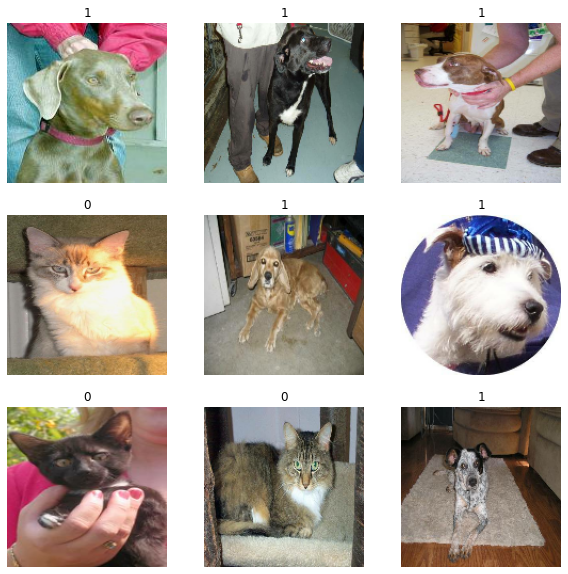

In [15]:
# Visualizar algumas das imagens. Onde o numero acima da imagen indica o indice da classe. 1 para cães e 0 para gatos.

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [16]:
# Aplicando algumas transformações nas imagens, para aumentar o dataset

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

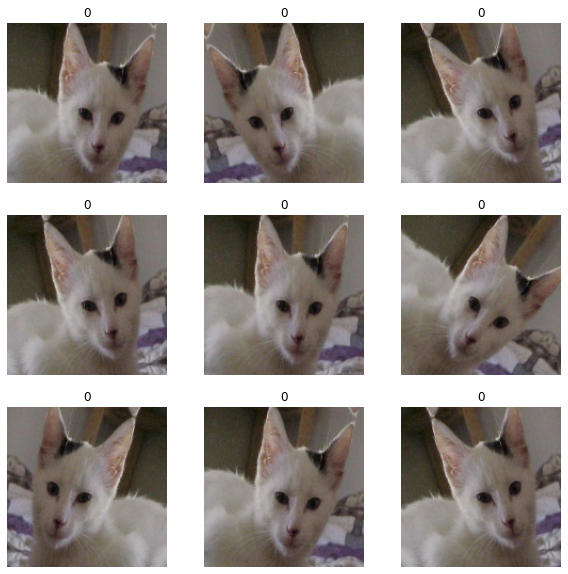

In [17]:
import numpy as np
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

## Construindo Modelo

In [18]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
#outputs = keras.layers.Dense(1)(x)
outputs = keras.layers.Dense(1, activation = "sigmoid")(x)
model = keras.Model(inputs, outputs)

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

## Treinando a Camada Superior

In [ ]:
#model_2.compile(
#    optimizer=keras.optimizers.Adam(),
#    loss=keras.losses.BinaryCrossentropy(from_logits=True),
#    metrics=[keras.metrics.BinaryAccuracy()],
#)

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)


epochs = 20
historico = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/20
625/625 [==============================] - 65s 81ms/step - loss: 0.1447 - accuracy: 0.9408 - val_loss: 0.0776 - val_accuracy: 0.9706
Epoch 2/20
625/625 [==============================] - 54s 85ms/step - loss: 0.1138 - accuracy: 0.9537 - val_loss: 0.0732 - val_accuracy: 0.9704
Epoch 3/20
625/625 [==============================] - 53s 84ms/step - loss: 0.1059 - accuracy: 0.9586 - val_loss: 0.0724 - val_accuracy: 0.9702
Epoch 4/20
625/625 [==============================] - 52s 83ms/step - loss: 0.1065 - accuracy: 0.9560 - val_loss: 0.0697 - val_accuracy: 0.9720
Epoch 5/20
625/625 [==============================] - 53s 84ms/step - loss: 0.1052 - accuracy: 0.9572 - val_loss: 0.0675 - val_accuracy: 0.9720
Epoch 6/20
625/625 [==============================] - 55s 88ms/step - loss: 0.1037 - accuracy: 0.9580 - val_loss: 0.0709 - val_accuracy: 0.9710
Epoch 7/20
625/625 [==============================] - 53s 85ms/step - loss: 0.0985 - accuracy: 0.9604 - val_loss: 0.0730 - val_accuracy:

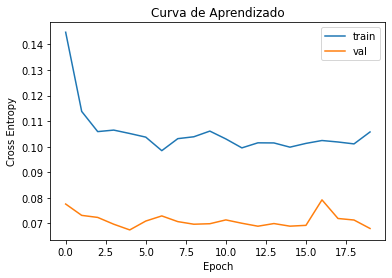

In [ ]:
# Cruva de aprendizado [7]
from matplotlib import pyplot

pyplot.title('Curva de Aprendizado')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.plot(historico.history['loss'], label='train')
pyplot.plot(historico.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

## Ajuste fino em todo o modelo

Finalmente, vamos descongelar o modelo base e treinar todo o modelo de ponta a ponta com uma baixa taxa de aprendizado.

É importante ressaltar que, embora o modelo base se torne treinável, ele ainda está sendo executado no modo de inferência, pois passamos training=False ao chamá-lo quando construímos o modelo. Isso significa que as camadas de normalização de lote internas não atualizarão suas estatísticas de lote. Se o fizessem, causariam estragos nas representações aprendidas pelo modelo até agora.

In [ ]:
base_model.trainable = True
model.summary()
"""
model_2.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)
"""
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss="binary_crossentropy",
    metrics=["accuracy"],
)



epochs = 5
historico = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

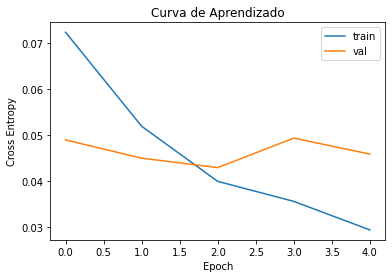

In [ ]:
# Cruva de aprendizado [6]
from matplotlib import pyplot

pyplot.title('Curva de Aprendizado')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.plot(historico.history['loss'], label='train')
pyplot.plot(historico.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

## Predição

### Imagen Unica

[[0.97667503]]
This image is 2.33 percent cat and 97.67 percent dog.


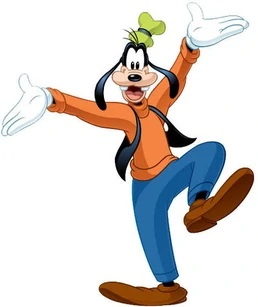

In [ ]:
filename = "/content/Dog_Cat/dataset_teste_local/dogs/A (3).jpg"


img = keras.preprocessing.image.load_img(
    filename, target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(predictions)
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)
from IPython.display import Image, display
display(Image(filename))

### Multiplas imagens

In [ ]:
numero_imagens = 100
confianca = 99 # se o modelo tiver 80% ou mais de certeza que a imagem é de um cão, então ela sera classificada como cão

cao = 0
gato = 0

for i in range(numero_imagens):
  filename = '/content/Dog_Cat/dataset_teste_local/cats/A (' + str(i+1) + ').jpg'
  #filename = '/content/Dog_Cat/dataset_teste/' + str(i+1) + '.jpg'

  img = keras.preprocessing.image.load_img(
     filename, target_size=image_size
  )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis

  predictions = model.predict(img_array)
  score = predictions[0]

  
  if (100*score) >= confianca: # ser cão
     cao = cao +1
  else:
    if (100 * (1 - score)) >= confianca: # ser gato
      gato = gato +1

nao_sabe = numero_imagens - (cao + gato)
porcentagem_gato = (gato / numero_imagens) * 100
porcentagem_cao = (cao / numero_imagens) * 100
porcentagem_nao_sabe = (nao_sabe / numero_imagens) * 100
      
print("Das "+ str(numero_imagens) + " Analisada: " + str(cao) +" ("+ str(porcentagem_cao) +" %)"+ " são de cachorros e "
     +  str(gato) +" ("+ str(porcentagem_gato) +" %)" + " são de gatos." + " Com "
     + str(confianca) +"% ou mais de confiança.")
print("E "+ str( nao_sabe) +" ("+ str(porcentagem_nao_sabe) +" %)" + " tem menos de " + str(confianca) + "% de certeza se é gato ou cão.")

Das 100 Analisada: 0 (0.0 %) são de cachorros e 100 (100.0 %) são de gatos. Com 99% ou mais de confiança.
E 0 (0.0 %) tem menos de 99% de certeza se é gato ou cão.


### Predição para CSV

In [ ]:
# Cria um dataframe para as previsões do modelo
import pandas as pd

# Criando o DataFrame vazio
df_xception = pd.DataFrame([], columns=['Amostra', 'Precisao', 'Gatos', 'Cachorros', 'Incertos'])

In [ ]:
# Realizar as medições
numero_imagens = 100


Amostra = 1  #  1 para cães e 0 para gatos.
while (Amostra >= 0):

  if(Amostra == 1):
    nome = "cachorros"
  else:
    nome = "gatos"
  
  for confianca in range(50, 101): # Medir a confianca entre 50% e 100%
    print(nome +": Executando: " + str(confianca) + "% confiança.") 
    
    cao = 0 # quantidade de imagens classificadas com cão 
    gato = 0 # quantidade de imagens classificadas com gato

    for i in range(numero_imagens):
      filename = '/content/Dog_Cat/dts/cats/A (' + str(i+1) + ').jpg'
      #filename = '/content/Dog_Cat/dataset_teste/' + str(i+1) + '.jpg'

      img = keras.preprocessing.image.load_img(
        filename, target_size=image_size
      )
      img_array = keras.preprocessing.image.img_to_array(img)
      img_array = tf.expand_dims(img_array, 0)  # Create batch axis

      predictions = model.predict(img_array)
      score = predictions[0]

      
      if (100*score) >= confianca: # ser cão
        cao = cao +1
      else:
        if (100 * (1 - score)) >= confianca: # ser gato
          gato = gato +1

    nao_sabe = numero_imagens - (cao + gato)
    porcentagem_gato = (gato / numero_imagens) * 100
    porcentagem_cao = (cao / numero_imagens) * 100
    porcentagem_nao_sabe = (nao_sabe / numero_imagens) * 100
          
    # Adiciona o resultado na Tabela
    df_xception = df_xception.append({'Amostra' : nome , 'Precisao' : confianca, 'Gatos' : porcentagem_gato,
                                                             'Cachorros' : porcentagem_cao, 'Incertos' : porcentagem_nao_sabe} , ignore_index=True)
  Amostra = Amostra -1

In [ ]:
#Criando o CSV
Nome_arquivo = "450_epocs_dataset_balanceado_Xception.csv"
df_xception.to_csv(Nome_arquivo, index = False)

# Extras

In [ ]:
# Apagar diretorio com arquivos

import shutil
pasta = "/content/Dog_Cat/train"
shutil.rmtree(pasta, ignore_errors=True)

In [ ]:
# Apagar arquivos

import os

for i in range(100):
  os.remove('/content/Dog_Cat/dataset_teste_local/A (' + str(i+1) + ').jpg')


In [ ]:
# mostra o que comtem em um diretorio
import os
os.listdir("/content/Dog_Cat/")

['dataset',
 'dataset_teste_local',
 'sampleSubmission.csv',
 'train.zip',
 'dataset_teste',
 'test1.zip']

# Referencias

[1] Baixar dados do Keggle. [video] https://www.youtube.com/watch?v=57N1g8k2Hwc \
[2] Baixar dados do Keggle. [Site] https://www.kaggle.com/general/74235 \
[3] DataSet com as imagens de cães e gatos do keggle: https://www.kaggle.com/c/dogs-vs-cats/data \
[4] Pagina das reagras para poder baixar o dataset: https://www.kaggle.com/competitions/dogs-vs-cats/rules \

[5] modelo pre-teinado xception https://keras-io.translate.goog/guides/transfer_learning/?_x_tr_sl=auto&_x_tr_tl=pt&_x_tr_hl=pt-BR \

[6] Explicação da rede Xception: https://maelfabien-github-io.translate.goog/deeplearning/xception/?_x_tr_sl=en&_x_tr_tl=pt&_x_tr_hl=pt-BR&_x_tr_pto=sc \

[7] Curva de aprendizado https://jobu.com.br/2021/07/15/tutorial-do-tensorflow-2/

